<a href="https://colab.research.google.com/github/LorenzoAristi/cm3-website/blob/main/CM4_Machine_Learning_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A little about Colab notebooks

This is a text "cell" it doesn't run code.

In [ ]:
# This is a code cell - it DOES run code.

## Case 1: A/B Test

In [ ]:
import pandas as pd
import numpy as np

# Generate sample data
np.random.seed(42)
n_samples = 1000

def generate_data(ctr_mean, time_mean):
    ctr = np.random.binomial(1, ctr_mean, n_samples)
    time = np.random.exponential(time_mean, n_samples)
    return pd.DataFrame({'CTR': ctr, 'Time': time})

control_data = generate_data(0.15, 60)
variant_a_data = generate_data(0.18, 65)
variant_b_data = generate_data(0.17, 70)

# Display summary statistics
print(control_data.describe())
print(variant_a_data.describe())
print(variant_b_data.describe())

               CTR         Time
count  1000.000000  1000.000000
mean      0.153000    62.106822
std       0.360168    62.851968
min       0.000000     0.193407
25%       0.000000    16.551084
50%       0.000000    43.880111
75%       0.000000    85.743407
max       1.000000   446.503375
               CTR         Time
count  1000.000000  1000.000000
mean      0.187000    62.475922
std       0.390107    62.889746
min       0.000000     0.042484
25%       0.000000    18.001167
50%       0.000000    43.042352
75%       0.000000    86.947898
max       1.000000   502.029419
               CTR         Time
count  1000.000000  1000.000000
mean      0.157000    70.407251
std       0.363983    71.277699
min       0.000000     0.434212
25%       0.000000    20.079927
50%       0.000000    47.189480
75%       0.000000    94.255375
max       1.000000   513.730040


In [ ]:
from scipy import stats

def compare_variants(control, variant, metric):
    t_stat, p_value = stats.ttest_ind(control[metric], variant[metric])
    print(f"p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")
    # Calculate confidence interval
    diff = variant[metric].mean() - control[metric].mean()
    se = np.sqrt(variant[metric].var()/len(variant) + control[metric].var()/len(control))
    ci = stats.t.interval(0.95, len(variant)+len(control)-2, loc=diff, scale=se)

    print(f"95% CI: {ci}")

    return p_value < 0.05

print("Variant A vs Control (CTR):")
is_significant_a = compare_variants(control_data, variant_a_data, 'CTR')

print("\nVariant B vs Control (CTR):")
is_significant_b = compare_variants(control_data, variant_b_data, 'CTR')

Variant A vs Control (CTR):
p-value: 0.0430
The difference is statistically significant.
95% CI: (0.001072269123372993, 0.06692773087662701)

Variant B vs Control (CTR):
p-value: 0.8049
The difference is not statistically significant.
95% CI: (-0.027756386858951057, 0.035756386858951064)


In [ ]:
# Assuming 1 million monthly active users
monthly_users = 1_000_000
avg_order_value = 25  # in dollars

def calculate_impact(control_ctr, variant_ctr):
    control_conversions = control_ctr * monthly_users
    variant_conversions = variant_ctr * monthly_users
    additional_conversions = variant_conversions - control_conversions
    revenue_impact = additional_conversions * avg_order_value
    return additional_conversions, revenue_impact

control_ctr = control_data['CTR'].mean()
variant_a_ctr = variant_a_data['CTR'].mean()
variant_b_ctr = variant_b_data['CTR'].mean()

impact_a = calculate_impact(control_ctr, variant_a_ctr)
impact_b = calculate_impact(control_ctr, variant_b_ctr)

print(f"Potential monthly impact of Variant A: {impact_a[0]:.0f} additional conversions, ${impact_a[1]:,.0f} revenue")
print(f"Potential monthly impact of Variant B: {impact_b[0]:.0f} additional conversions, ${impact_b[1]:,.0f} revenue")

Potential monthly impact of Variant A: 34000 additional conversions, $850,000 revenue
Potential monthly impact of Variant B: 4000 additional conversions, $100,000 revenue



*   How do we determine if a result is statistically significant?
*   What factors might influence the reliability of our A/B test results?*   How should we balance statistical significance with practical significance?
*   What are some potential risks or ethical concerns with A/B testing?
*   How might we iterate on this test to gain more insights?

## Case 2: Customer Churn  

The code below

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/iamctodd/MCXI/refs/heads/main/telco-sm.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1409 non-null   int64  
 1   Avg Monthly GB Download            1409 non-null   int64  
 2   Avg Monthly Long Distance Charges  1409 non-null   float64
 3   Churn Category                     374 non-null    object 
 4   Churn Reason                       374 non-null    object 
 5   Churn Score                        1409 non-null   int64  
 6   City                               1409 non-null   object 
 7   CLTV                               1409 non-null   int64  
 8   Contract                           1409 non-null   object 
 9   Country                            1409 non-null   object 
 10  Customer ID                        1409 non-null   object 
 11  Customer Status                    1409 non-null   objec

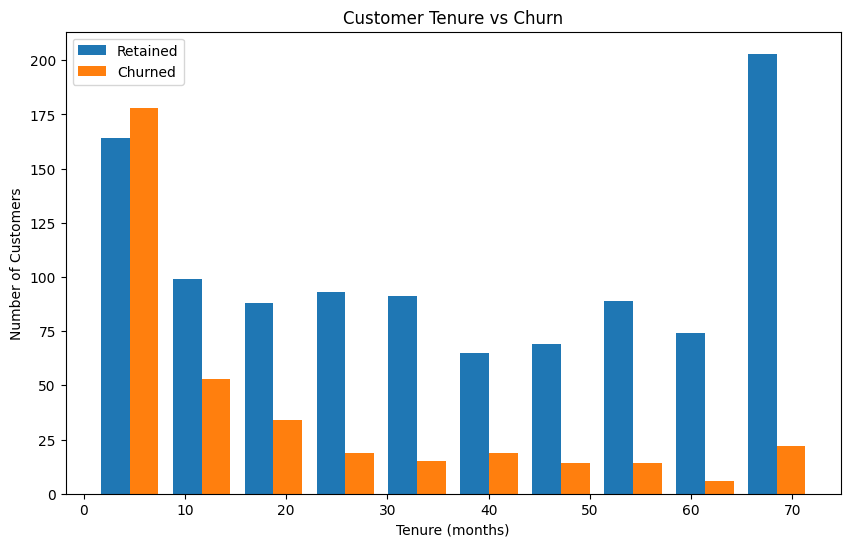

In [ ]:
# Visualize relationship between tenure and churn
plt.figure(figsize=(10,6))
plt.hist([df[df['Churn']== 0]['Tenure in Months'], df[df['Churn']== 1]['Tenure in Months']],
         label=['Retained', 'Churned'])
plt.legend()
plt.title('Customer Tenure vs Churn')
plt.xlabel('Tenure (months)')
plt.ylabel('Number of Customers')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Handle categorical variables
df2 = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df2.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred, pos_label=1):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label=1):.2f}")
    print(f"F1-score: {f1_score(y_true, y_pred, pos_label=1):.2f}\n")

evaluate_model(y_test, lr_pred, "Logistic Regression")
evaluate_model(y_test, rf_pred, "Random Forest")

Logistic Regression Performance:
Accuracy: 0.99
Precision: 1.00
Recall: 0.96
F1-score: 0.98

Random Forest Performance:
Accuracy: 0.99
Precision: 1.00
Recall: 0.97
F1-score: 0.99



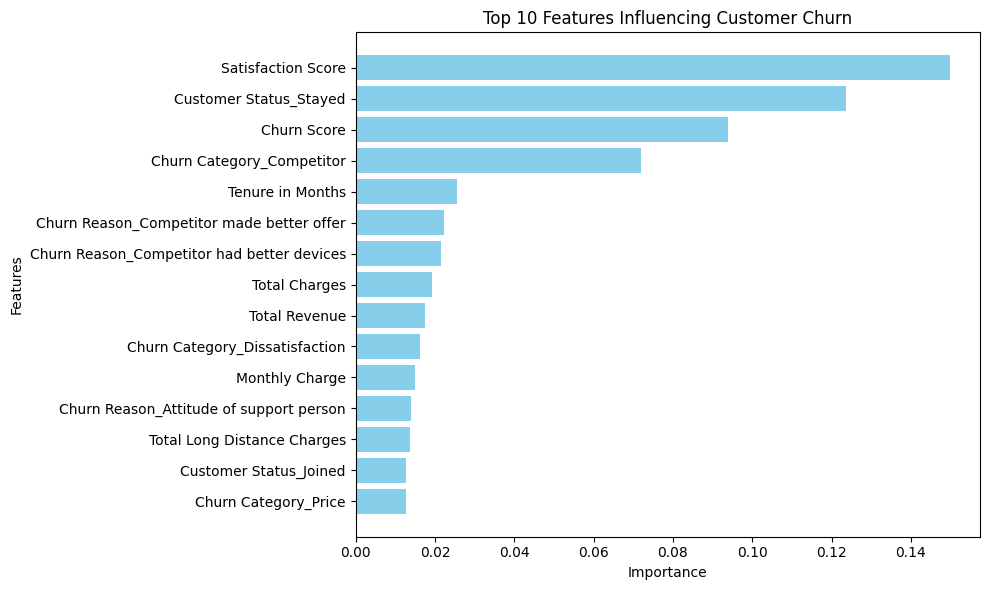

In [ ]:
# Get feature importances from Random Forest model
importances = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(importances['feature'], importances['importance'], color='skyblue')
plt.title('Top 10 Features Influencing Customer Churn')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### **Answer the following:**
* How accurate are our predictions? What does this mean for the business?
* What are the most important factors leading to customer churn?
* How could TeleCo use these insights to reduce churn?
* What ethical considerations should we keep in mind when using this model?
* How could we improve this model further?

## Case 3: Customer Segmentation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   User ID                   1000 non-null   int64  
 1   Daily Time Spent on Site  1000 non-null   float64
 2   Age                       1000 non-null   int64  
 3   EstimatedSalary           1000 non-null   int64  
 4   Daily Internet Usage      1000 non-null   float64
 5   Ad Topic Line             1000 non-null   object 
 6   City                      1000 non-null   object 
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Gender                    1000 non-null   object 
 10  Clicked                   1000 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 86.1+ KB
None
User ID                     0
Daily Time Spent on Site    0
Age                         0
EstimatedSalary      

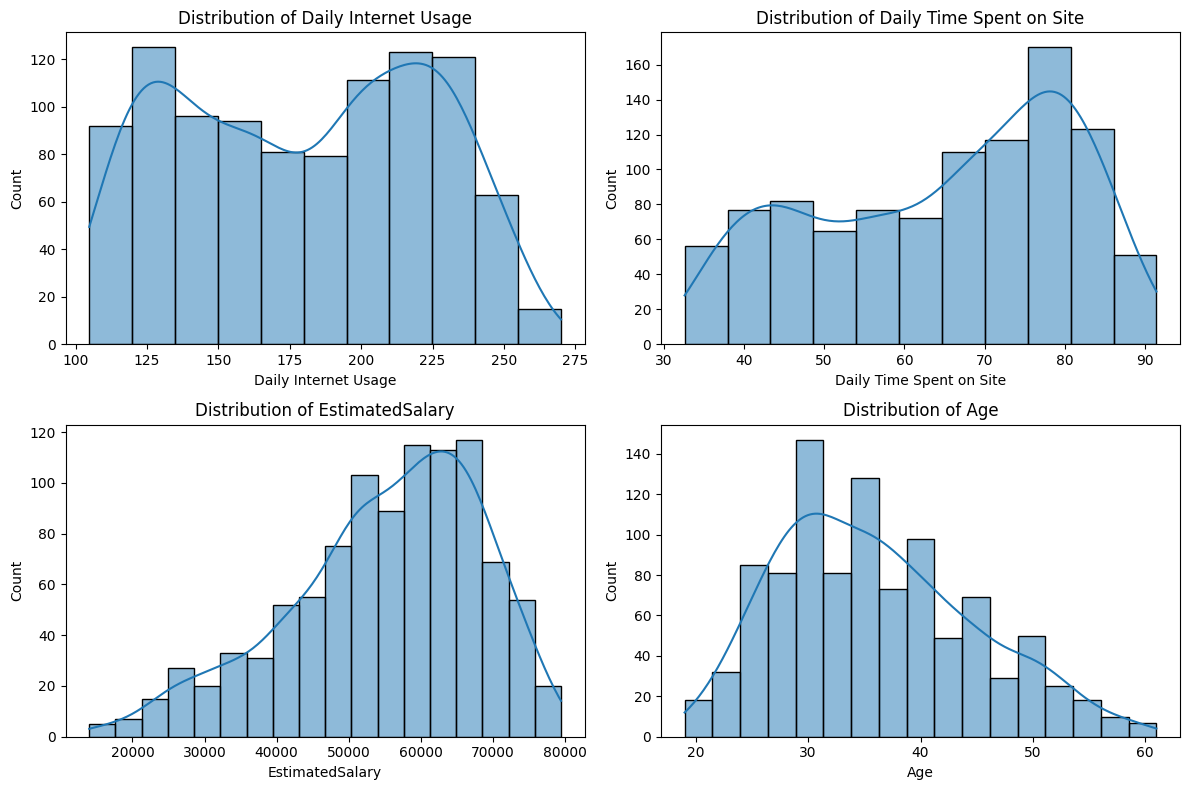

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the dataset
cmr = pd.read_csv('https://raw.githubusercontent.com/iamctodd/MCXI/refs/heads/main/advertising.csv')

# Explore the data
print(cmr.info())

# Check for missing values
print(cmr.isnull().sum())

# Basic statistics
print(cmr.describe())

# Visualize distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(['Daily Internet Usage', 'Daily Time Spent on Site', 'EstimatedSalary', 'Age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(cmr[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Select features for clustering
features = ['Daily Internet Usage', 'Daily Time Spent on Site', 'EstimatedSalary', 'Age']
X = cmr[features]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

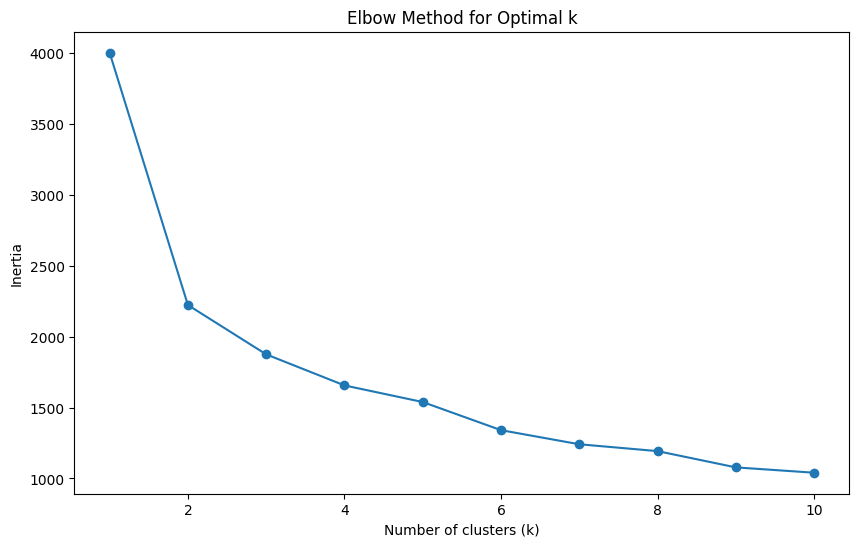

In [ ]:
# Elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

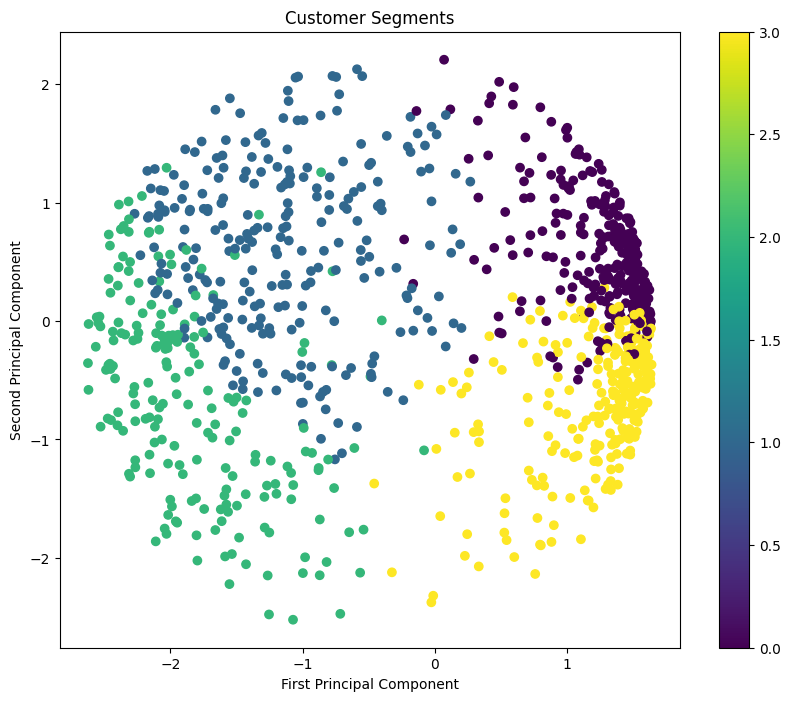

In [ ]:
# Choose the optimal number of clusters (4, but change this and re-run it!)
kmeans = KMeans(n_clusters=4, random_state=42)
cmr['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

In [ ]:
# Compute cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
cluster_centers_df

,Daily Internet Usage,Daily Time Spent on Site,EstimatedSalary,Age
0,216.304835,77.182344,65721.772894,36.131868
1,141.164202,50.548016,58387.805447,40.821012
2,142.880398,53.202637,34913.318408,41.925373
3,207.995242,75.259665,55891.167286,26.866171


In [ ]:
X['Cluster'] = kmeans.labels_ # Creates a NEW COLUMN in the drinks dataframe called  'cluster'

<ipython-input-41-96cfe8d3a08a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = kmeans.labels_ # Creates a NEW COLUMN in the drinks dataframe called  'cluster'


,Daily Internet Usage,Daily Time Spent on Site,EstimatedSalary,Age,Cluster
0,256.09,68.95,61834,35,0
1,193.77,80.23,68442,31,0


In [ ]:
X.groupby('Cluster').median()

,Daily Internet Usage,Daily Time Spent on Site,EstimatedSalary,Age
Cluster,,,,
0,219.91,78.35,66572.0,35.0
1,136.18,48.86,57595.0,41.0
2,136.64,52.13,36425.0,42.0
3,210.39,76.83,56975.0,27.0


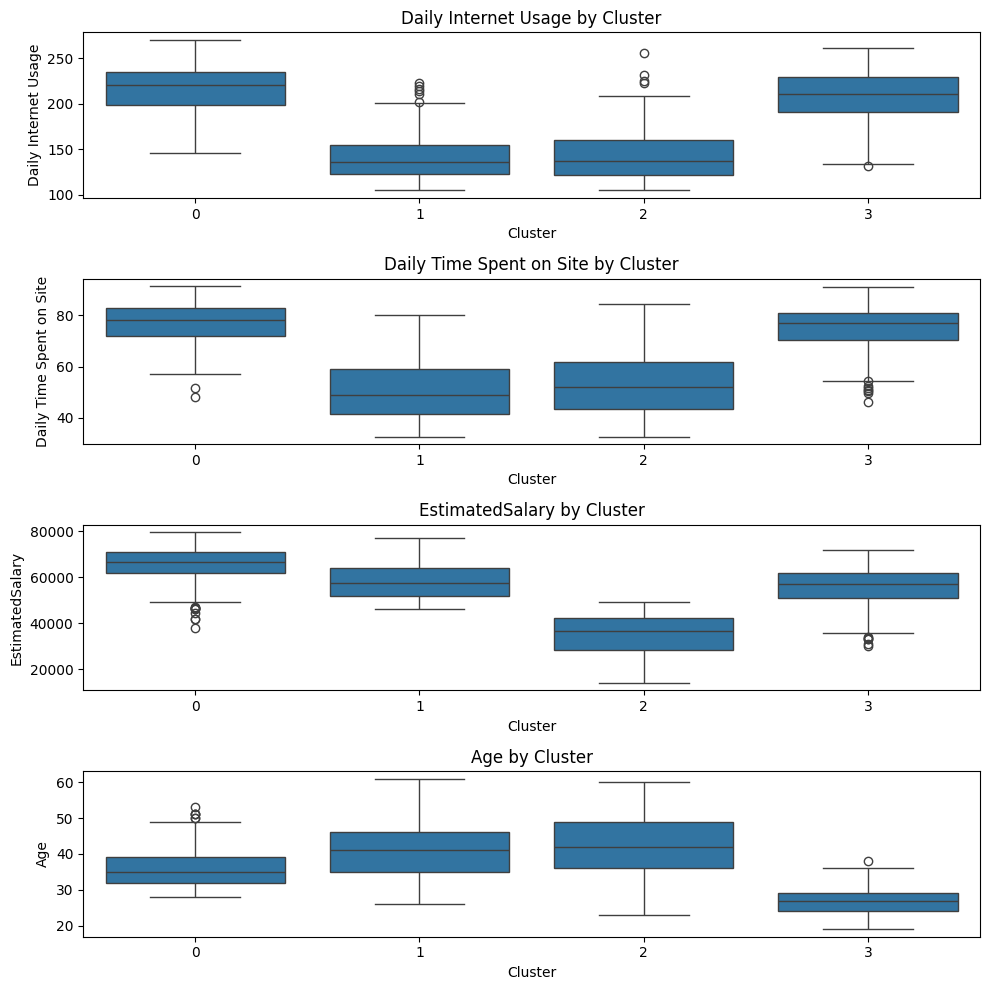

In [ ]:
# Visualize feature distributions across clusters
plt.figure(figsize=(10, 10))
for i, feature in enumerate(features):
    plt.subplot(4, 1, i+1)
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

**Questions:**
* How can we use these customer segments to create targeted marketing campaigns?
* What additional data might improve our segmentation?
* How often should we re-run this analysis to keep our segments up-to-date?
* What are the ethical considerations of using customer data for segmentation?
* What happens when the number of clusters (segments) changes?
* How can we validate the usefulness of these segments in a business context?

## Case 4: Handwritten Digit Recognition

Training samples: 60000
Test samples: 10000
Image shape: (28, 28)


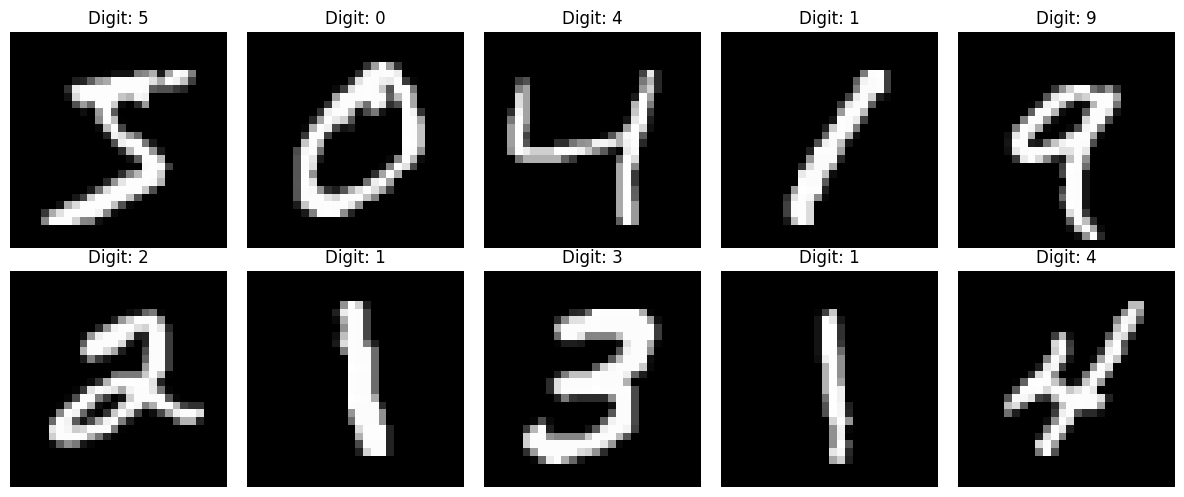

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Explore the data
print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train[0].shape}")

# Visualize some samples
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Digit: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Normalize pixel values
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape for model input
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 67s 147ms/step - accuracy: 0.7570 - loss: 0.7958 - val_accuracy: 0.9787 - val_loss: 0.0778
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 51s 121ms/step - accuracy: 0.9650 - loss: 0.1180 - val_accuracy: 0.9863 - val_loss: 0.0527
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 86s 131ms/step - accuracy: 0.9746 - loss: 0.0838 - val_accuracy: 0.9887 - val_loss: 0.0451
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 74s 113ms/step - accuracy: 0.9782 - loss: 0.0734 - val_accuracy: 0.9887 - val_loss: 0.0410
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 48s 113ms/step - accuracy: 0.9817 - loss: 0.0634 - val_accuracy: 0.9898 - val_loss: 0.0382


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9830 - loss: 0.0473
Test accuracy: 0.9868


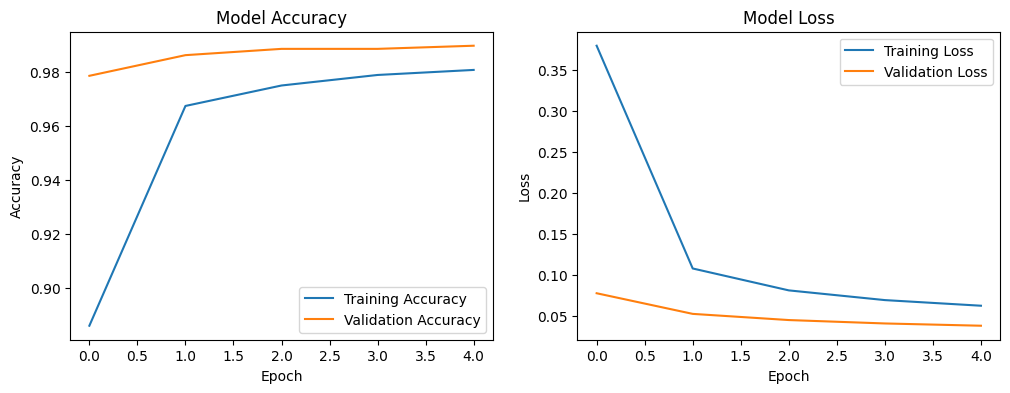

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


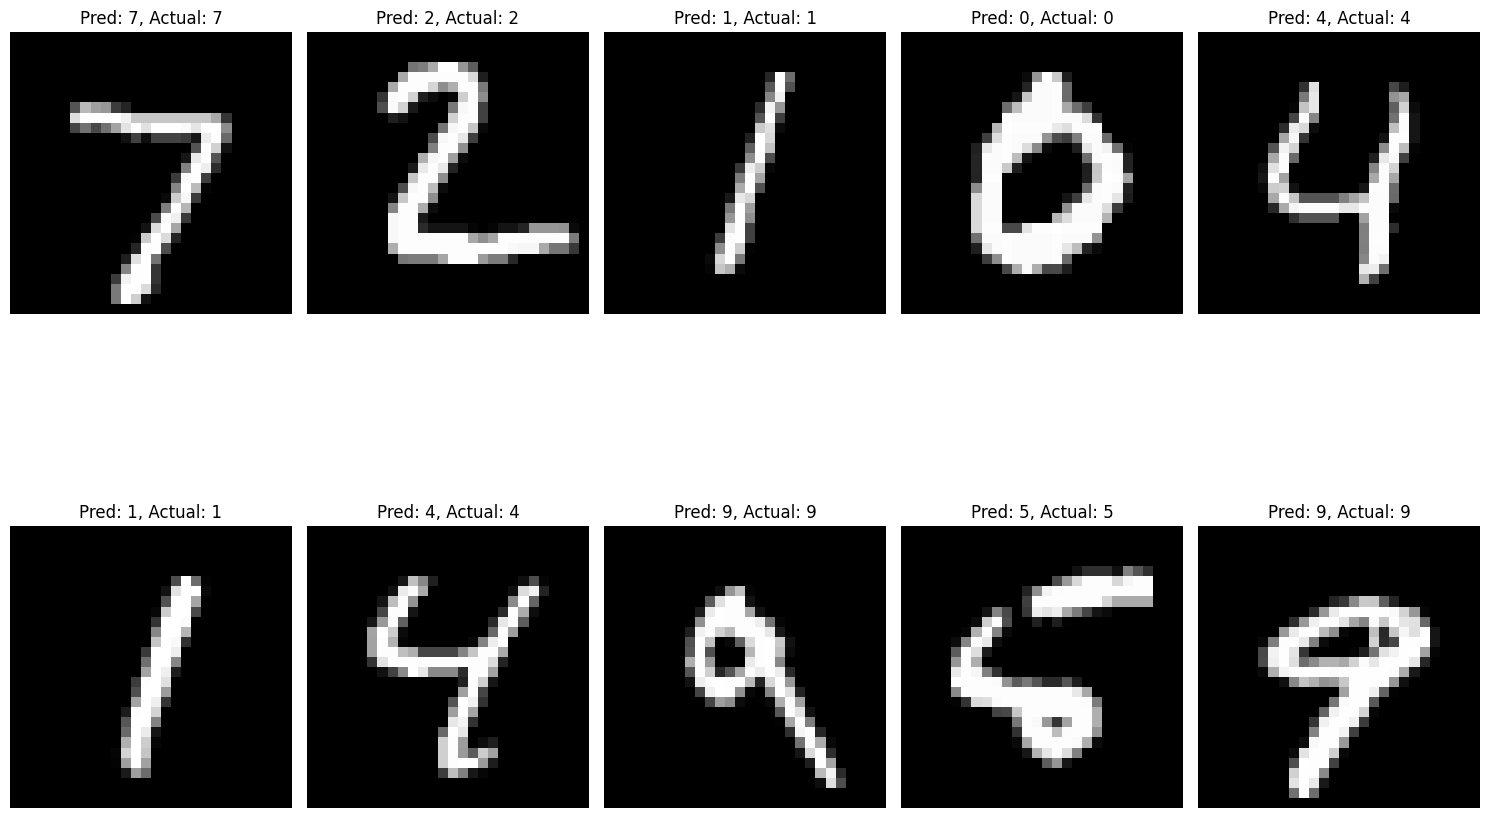

In [ ]:
# Visualize some predictions
predictions = model.predict(x_test)
fig, axs = plt.subplots(2, 5, figsize=(15, 12))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(x_test[i].reshape(28, 28), cmap='gray')
    predicted = np.argmax(predictions[i])
    actual = np.argmax(y_test[i])
    ax.set_title(f"Pred: {predicted}, Actual: {actual}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np

# Create a Function to predict input
def predict_digit():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = Image.open(filename)
        img = img.convert('L')
        img = img.resize((28, 28))
        plt.imshow(img) # cmap='gray'
        plt.show()
        img = np.array(img)
        img = img.reshape(1, 28, 28, 1)
        img = img.astype('float32')
        img /= 255
        result = model.predict(img)
        digit = np.argmax(result)
        print("Predicted digit:", digit)


Try it yourself! Write a number, snap aphotos and upload it. It must be a .png or .jpg file.

Saving letter_image_9.jpg to letter_image_9.jpg


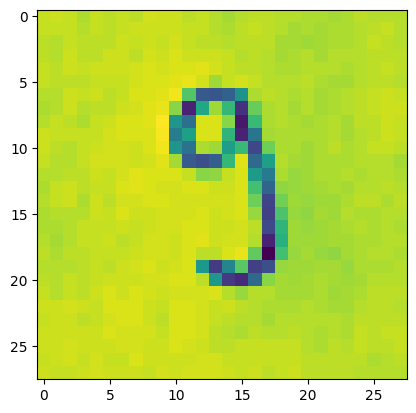

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted digit: 8


In [ ]:
predict_digit()

Questions
* How does the model's performance compare to human-level accuracy on digit recognition?
* How quickly did this model run compared to the others?
* What are real-world applications of this technology?
* How might this model fail or be biased? How could we address these issues?
* What ethical considerations should we keep in mind when developing and deploying computer vision systems?
* How could this technology be misused, and what safeguards might we implement?
* How does this simple digit recognition task relate to more complex computer vision tasks like facial recognition or autonomous driving?